In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv("factory_item_counts_5months_filtered.csv", parse_dates=["Datetime"])
df.set_index("Datetime", inplace=True)

# Resample hourly counts (optional if already evenly spaced)
ts = df["Item_Count"].asfreq('H')  # hourly frequency


In [3]:
df_hourly = df.groupby("Datetime")["Item_Count"].sum().asfreq("H")

In [4]:
df_hourly.head

<bound method NDFrame.head of Datetime
2024-11-01 08:00:00    0.0
2024-11-01 09:00:00    8.0
2024-11-01 10:00:00    9.0
2024-11-01 11:00:00    9.0
2024-11-01 12:00:00    8.0
                      ... 
2025-03-31 13:00:00    7.0
2025-03-31 14:00:00    6.0
2025-03-31 15:00:00    6.0
2025-03-31 16:00:00    5.0
2025-03-31 17:00:00    3.0
Freq: H, Name: Item_Count, Length: 3610, dtype: float64>

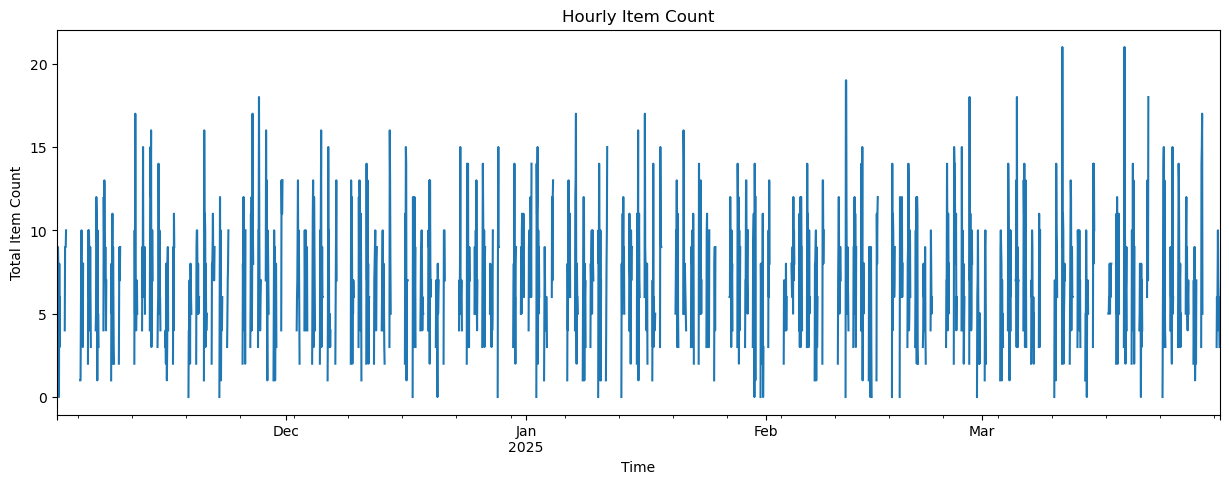

In [5]:
import matplotlib.pyplot as plt

df_hourly.plot(figsize=(15, 5), title="Hourly Item Count")
plt.xlabel("Time")
plt.ylabel("Total Item Count")
plt.show()


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA(p, d, q)(P, D, Q, s)
# Try: daily seasonality (s = 10 hours), or weekly (s = 10*6 = 60 hours)

model = SARIMAX(df_hourly,
                order=(1, 1, 1),         # ARIMA part
                seasonal_order=(1, 1, 1, 2),  # Seasonal: 60-hour period (~1 work week)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                        Item_Count   No. Observations:                 3610
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 2)   Log Likelihood               -3212.041
Date:                           Wed, 16 Apr 2025   AIC                           6434.082
Time:                                   13:09:49   BIC                           6465.029
Sample:                               11-01-2024   HQIC                          6445.110
                                    - 03-31-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0096      0.029      0.327      0.744      -0.048       0.067
ma.L1         -1.0003      0.022    -46.463

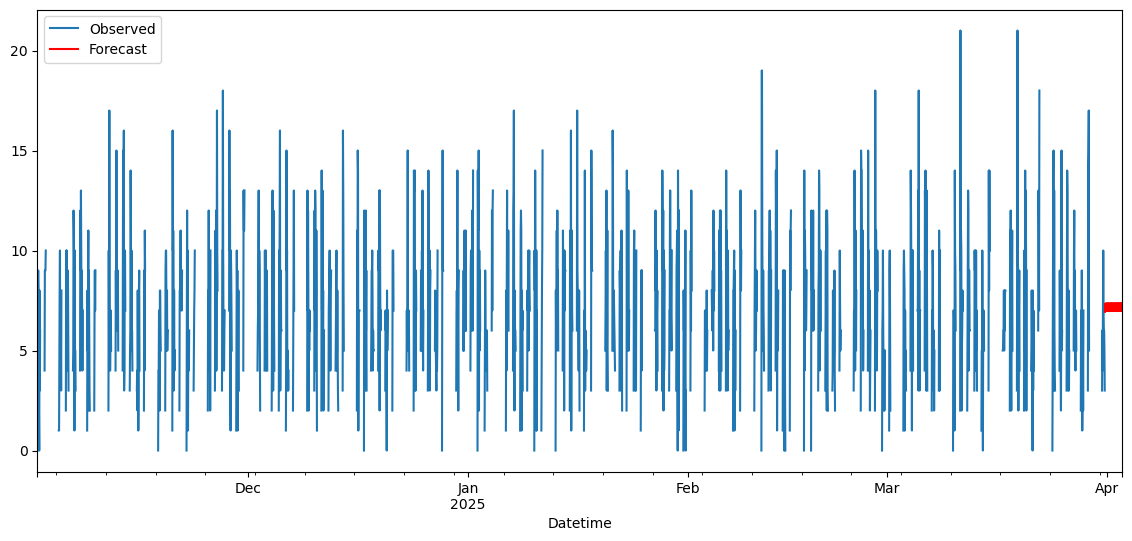

In [12]:
forecast = results.get_forecast(steps=60)  # forecast next 60 hours
forecast_df = forecast.summary_frame()

# Plot
df_hourly.plot(label='Observed', figsize=(14, 6))
forecast_df['mean'].plot(label='Forecast', color='red')
plt.legend()
plt.show()


In [13]:
print(forecast_df)


Item_Count               mean   mean_se  mean_ci_lower  mean_ci_upper
2025-03-31 18:00:00  6.934052  3.703195      -0.324077      14.192181
2025-03-31 19:00:00  7.345054  3.703583       0.086164      14.603943
2025-03-31 20:00:00  6.977010  3.703481      -0.281679      14.235699
2025-03-31 21:00:00  7.348072  3.703606       0.089137      14.607007
2025-03-31 22:00:00  6.977104  3.703492      -0.281607      14.235814
2025-03-31 23:00:00  7.348138  3.703617       0.089182      14.607095
2025-04-01 00:00:00  6.977168  3.703503      -0.281564      14.235901
2025-04-01 01:00:00  7.348203  3.703629       0.089224      14.607182
2025-04-01 02:00:00  6.977233  3.703514      -0.281522      14.235988
2025-04-01 03:00:00  7.348268  3.703640       0.089267      14.607269
2025-04-01 04:00:00  6.977298  3.703526      -0.281479      14.236075
2025-04-01 05:00:00  7.348333  3.703651       0.089310      14.607355
2025-04-01 06:00:00  6.977363  3.703537      -0.281436      14.236161
2025-04-01 07:00:00 

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load and prepare
df = pd.read_csv("factory_item_counts_5months_filtered.csv", parse_dates=["Datetime"])
df_hourly = df.groupby("Datetime")["Item_Count"].sum().asfreq("H").fillna(0)

# Scale data between 0 and 1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_hourly.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10  # One day of history (10 hours or 24 for full-hour coverage)
X, y = create_sequences(scaled, window_size)


In [24]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [25]:
X_train

array([[[0.        ],
        [0.38095238],
        [0.42857143],
        ...,
        [0.38095238],
        [0.14285714],
        [0.28571429]],

       [[0.38095238],
        [0.42857143],
        [0.42857143],
        ...,
        [0.14285714],
        [0.28571429],
        [0.        ]],

       [[0.42857143],
        [0.42857143],
        [0.38095238],
        ...,
        [0.28571429],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.0952381 ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.04761905],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.04761905],
        [0.42857143],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
90/90 [==============================] - 1s 5ms/step - loss: 0.0280 - val_loss: 0.0212
Epoch 2/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0193 - val_loss: 0.0202
Epoch 3/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0184 - val_loss: 0.0197
Epoch 4/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0178 - val_loss: 0.0185
Epoch 5/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0167 - val_loss: 0.0176
Epoch 6/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 7/20
90/90 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 8/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0163
Epoch 9/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0159
Epoch 10/20
90/90 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0157
Epoch 11/20
90/90 [

23/23 [==============================] - 0s 2ms/step


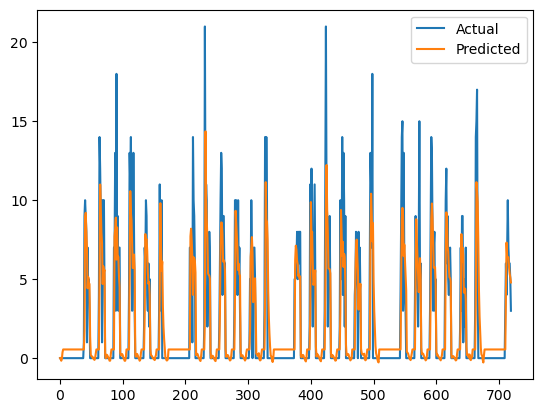

In [29]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)

# Optional: plot
import matplotlib.pyplot as plt
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()
